In [79]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
data = pd.read_csv('log2.csv')

In [81]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


Text(0, 0.5, 'Frequency')

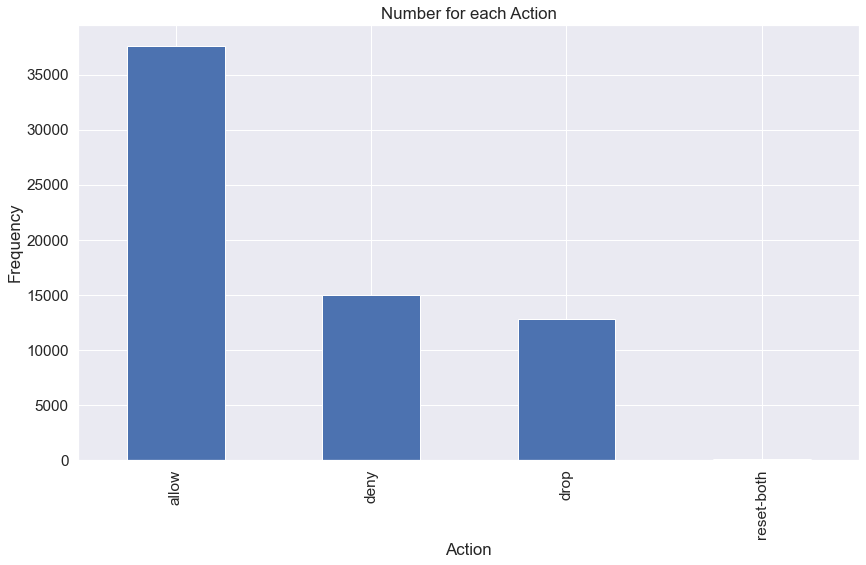

In [162]:
ax = data['Action'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Action")
ax.set_xlabel("Action")
ax.set_ylabel("Frequency")

In [83]:
data['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [84]:
data_y = data['Action']
data_x = data.drop('Action', axis=1)

In [85]:
data_y.head()

0    allow
1    allow
2    allow
3    allow
4    allow
Name: Action, dtype: object

In [86]:
data_x.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,177,94,83,2,30,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,13,18


In [87]:
from imblearn.over_sampling import SMOTE

In [88]:
oversample_smote = SMOTE()

In [89]:
X_over, y_over = oversample_smote.fit_resample(data_x, data_y)

In [90]:
frame = {'label':y_over}

In [91]:
df_y_over = pd.DataFrame(frame)

Text(0, 0.5, 'Frequency')

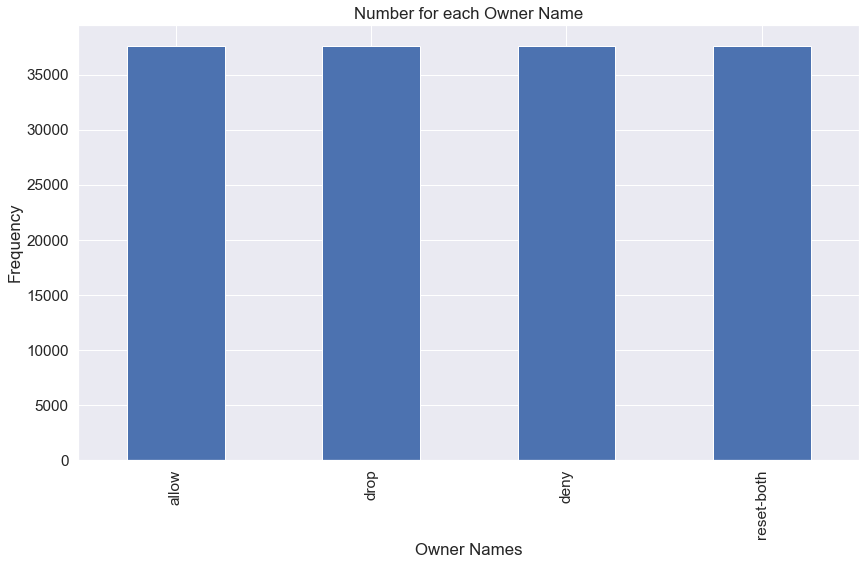

In [92]:
ax = df_y_over['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Owner Name")
ax.set_xlabel("Owner Names")
ax.set_ylabel("Frequency")

In [93]:
df_y_over

,label
0,allow
1,allow
2,allow
3,allow
4,allow
...,...
150555,reset-both
150556,reset-both
150557,reset-both
150558,reset-both


In [94]:
X_over

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,177,94,83,2,30,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...
150555,2137,23542,0,0,152,152,0,1,0,1,0
150556,14260,28053,0,0,62,62,0,1,0,1,0
150557,15691,25073,0,0,81,81,0,1,0,1,0
150558,52412,33528,0,0,62,62,0,1,0,1,0


In [95]:
df_new = pd.concat([X_over, df_y_over], axis=1)

In [96]:
#ดู destination port กับ nat destination port มันเหมือนกัน แต่ถ้า nat เป็น 0 ส่วนมากมันจะเป็น allow

# Source Port VS NAT Source Port

In [97]:
df_new['Check-SP-NSP-Equal'] = np.where(df_new['Source Port'] == df_new['NAT Source Port'], True, False)

In [98]:
table1 = pd.pivot_table(df_new, values='Source Port', index=['label'],
                       columns=['Check-SP-NSP-Equal'], aggfunc='count')
table1

Check-SP-NSP-Equal,False,True
label,,
allow,34477.0,3163.0
deny,37374.0,266.0
drop,37640.0,NaN
reset-both,29710.0,7930.0


# NAT Destination Port

In [99]:
#NAT Destination Port
df_new['is-NDP-0'] = np.where(df_new['NAT Destination Port'] == 0, True, False)

In [100]:
table2 = pd.pivot_table(df_new, values='Source Port', index=['label'],
                       columns=['is-NDP-0'], aggfunc='count')
table2

is-NDP-0,False,True
label,,
allow,37076.0,564.0
deny,34.0,37606.0
drop,NaN,37640.0
reset-both,9052.0,28588.0


In [101]:
# [Byte, Bytesent, Packet, pkt_sent] , ['Bytes Receive', 'pkts_Receive']

In [102]:
def NormalizeData(column):
    return (column - column.min()) / (column.max() - column.min())

In [103]:
columns = ['Bytes', 'Bytes Sent', 'Packets', 'pkts_sent']
df_new_corr = df_new[['Bytes', 'Bytes Sent', 'Packets', 'pkts_sent']]

In [104]:
for i in columns:
    df_new_corr[i] = NormalizeData(df_new_corr[i])

C:\Users\KANISO~1\AppData\Local\Temp/ipykernel_19884/1542359921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_corr[i] = NormalizeData(df_new_corr[i])


In [105]:
df_new_corr.head()

,Bytes,Bytes Sent,Packets,pkts_sent
0,9.217251e-08,3.584694e-08,9.651438e-07,0.000000
1,3.708959e-06,1.623655e-06,1.737259e-05,0.000012
2,1.402283e-07,6.115066e-08,9.651438e-07,0.000000
3,2.573740e-06,1.452855e-06,1.351201e-05,0.000009
4,1.992974e-05,7.082933e-06,2.895431e-05,0.000016


<AxesSubplot:>

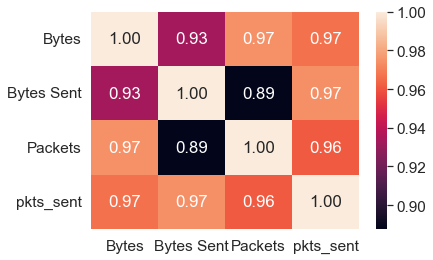

In [106]:
cormat = df_new_corr.corr()
round(cormat,2)
sns.heatmap(cormat, annot=True, fmt='.2f')

In [107]:
table2 = pd.pivot_table(df_new, values=['Bytes', 'Bytes Sent', 'Packets', 'pkts_sent'], index=['label'], aggfunc=np.mean)
table2

,Bytes,Bytes Sent,Packets,pkts_sent
label,,,,
allow,169037.953241,38917.411743,178.348565,71.334883
deny,82.070510,81.846015,1.003587,1.002311
drop,68.711211,68.711211,1.000000,1.000000
reset-both,157.944421,142.150691,1.662380,1.436610


In [108]:
columns_receive = ['Bytes Received', 'pkts_received']
df_new_rev_corr = df_new[['Bytes Received', 'pkts_received']]

In [109]:
for i in columns_receive:
    df_new_rev_corr[i] = NormalizeData(df_new_rev_corr[i])

C:\Users\KANISO~1\AppData\Local\Temp/ipykernel_19884/3062420973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_rev_corr[i] = NormalizeData(df_new_rev_corr[i])


<AxesSubplot:>

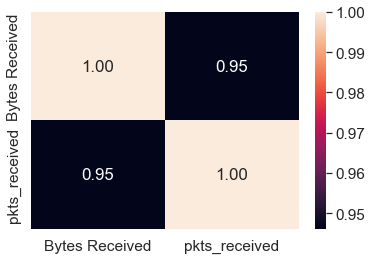

In [110]:
cormat2 = df_new_rev_corr.corr()
round(cormat2,2)
sns.heatmap(cormat2, annot=True, fmt='.2f')

In [111]:
table_receive = pd.pivot_table(df_new, values=['Bytes Received', 'pkts_received'], index=['label'], aggfunc=np.mean)
table_receive

,Bytes Received,pkts_received
label,,
allow,130120.541498,107.013682
deny,0.224416,0.001249
drop,0.000000,0.000000
reset-both,15.778773,0.210680


# Elapsed Time

In [112]:
# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=test_size, random_state=seed)

In [116]:
X_train_x_2 = X_train.drop(['Source Port', 'NAT Source Port','Destination Port','Packets','pkts_sent','Bytes','pkts_received'], axis=1)

In [117]:
X_train_x_2['checkNAT'] = [0 if x ==0 else 1 for x in X_train_x_2['NAT Destination Port']]

In [118]:
X_train_x_2 = X_train_x_2.drop('NAT Destination Port', axis=1)

In [119]:
X_train_x_2.head()

,Bytes Sent,Bytes Received,Elapsed Time (sec),checkNAT
17587,93,662,31,1
96776,70,0,0,0
81064,65,0,0,0
110394,66,0,0,0
48687,70,0,0,0


In [120]:
model2 = XGBClassifier()
model2.fit(X_train_x_2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [121]:
X_test_x_2 = X_test.drop(['Source Port', 'NAT Source Port','Destination Port','Packets','pkts_sent','Bytes','pkts_received'], axis=1)
y_test.replace({'allow': 0, 'deny': 1, 'drop':2, 'reset-both':3}, inplace=True)

In [122]:
X_test_x_2['checkNAT'] = [0 if x ==0 else 1 for x in X_test_x_2['NAT Destination Port']]

In [123]:
X_test_x_2 = X_test_x_2.drop('NAT Destination Port', axis=1)

In [124]:
# make predictions for test data
y_pred_2 = model2.predict(X_test_x_2)
predictions_2 = [round(value) for value in y_pred_2]

In [125]:
# evaluate predictions
accuracy_2 = accuracy_score(y_test, predictions_2)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))

Accuracy: 85.59%


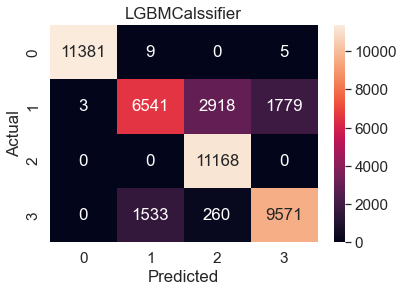

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11395
           1       0.81      0.58      0.68     11241
           2       0.78      1.00      0.88     11168
           3       0.84      0.84      0.84     11364

    accuracy                           0.86     45168
   macro avg       0.86      0.86      0.85     45168
weighted avg       0.86      0.86      0.85     45168



In [126]:
data_graph = pd.DataFrame({'test': y_test,'pred': y_pred_2})
confusion_matrix = pd.crosstab(data_graph.test, data_graph.pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
sns.set(font_scale=1.4)
plt.title(f'LGBMCalssifier')
plt.show()
print(metrics.classification_report(y_test, y_pred_2))

In [127]:
confusion_matrix

Predicted,0,1,2,3
Actual,,,,
0,11381,9,0,5
1,3,6541,2918,1779
2,0,0,11168,0
3,0,1533,260,9571


# ROC Curve (One VS Rest)

In [138]:
y_test_Allow = [1 if y == 0 else 0 for y in y_test]
y_pred_2_Allow = [1 if y == 0 else 0 for y in y_pred_2]
y_test_Deny = [1 if y == 1 else 0 for y in y_test]
y_pred_2_Deny = [1 if y == 1 else 0 for y in y_pred_2]
y_test_Drop = [1 if y == 2 else 0 for y in y_test]
y_pred_2_Drop = [1 if y == 2 else 0 for y in y_pred_2]
y_test_reset = [1 if y == 3 else 0 for y in y_test]
y_pred_2_reset = [1 if y == 3 else 0 for y in y_pred_2]

In [156]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test_Allow, y_pred_2_Allow)
roc_auc0 = round((metrics.auc(fpr0, tpr0)), 2)
roc_auc0

1.0

In [157]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test_Deny, y_pred_2_Deny)
roc_auc1 = round((metrics.auc(fpr1, tpr1)), 2)
roc_auc1

0.77

In [158]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test_Drop, y_pred_2_Drop)
roc_auc2 = round((metrics.auc(fpr2, tpr2)), 2)
roc_auc2

0.95

In [159]:
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test_reset, y_pred_2_reset)
roc_auc3 = round((metrics.auc(fpr3, tpr3)), 2)
roc_auc3

0.89

In [148]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = ['0', '1', '2', '3']
fpr[0] = fpr0
tpr[0] = tpr0
fpr[1] = fpr1
tpr[1] = tpr1
fpr[2] = fpr2
tpr[2] = tpr2
fpr[3] = fpr3
tpr[3] = tpr3
roc_auc[0] = roc_auc0
roc_auc[1] = roc_auc1
roc_auc[2] = roc_auc2
roc_auc[3] = roc_auc3
#for i in range(n_classes):
#    roc_auc[i] = auc(fpr[i], tpr[i])

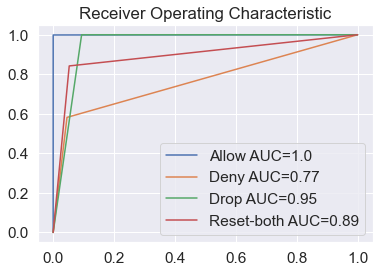

In [161]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr0,tpr0,label="Allow AUC="+str(roc_auc0))
plt.plot(fpr1,tpr1,label="Deny AUC="+str(roc_auc1))
plt.plot(fpr2,tpr2,label="Drop AUC="+str(roc_auc2))
plt.plot(fpr3,tpr3,label="Reset-both AUC="+str(roc_auc3))
plt.legend()